In [1]:
import sys
from git_root import git_root

import numpy as np
import tensorflow as tf

from fetch_data import fetch_data_cloud

train_df = fetch_data_cloud(map_type='mel_map', train=True, angle='0')
test_df = fetch_data_cloud(map_type='mel_map', train=False, angle='0')

Fetching: data/preprocessed_data/mel_map/data_mel_map_angle_0_train.json
Fetching: data/preprocessed_data/mel_map/data_mel_map_angle_0_test.json


In [2]:
from fetch_data import to_numpy_arrays, prepare_tf_dataset

train_samples, train_labels = to_numpy_arrays(train_df)
test_samples, test_labels = to_numpy_arrays(train_df)

train_dataset = prepare_tf_dataset(train_samples, train_labels)
test_dataset = prepare_tf_dataset(test_samples, test_labels)

In [3]:
#Load the utils module
sys.path.append(git_root("models"))
from GLCM_model import setup_model

#We load the model
net = setup_model()

net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 12)        444       
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 5, 12)          0         
_________________________________________________________________
affine_scalar (AffineScalar) (None, 5, 5, 12)          2         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 6)           654       
_________________________________________________________________
global_average_pooling2d (Gl (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                70        
Total params: 1,170
Trainable params: 1,170
Non-trainable params: 0
______________________________________________________

In [4]:
from tensorflow.keras.optimizers import Adam

net.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = net.fit(train_dataset, epochs=400, validation_data=test_dataset)

Epoch 1/400
394/394 [==============================] - 8s 20ms/step - loss: 2.3226 - accuracy: 0.0623 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/400
394/394 [==============================] - 6s 14ms/step - loss: 2.3068 - accuracy: 0.0784 - val_loss: 2.2905 - val_accuracy: 0.1275
Epoch 3/400
394/394 [==============================] - 6s 14ms/step - loss: 2.3002 - accuracy: 0.0868 - val_loss: 2.2846 - val_accuracy: 0.1288
Epoch 4/400
394/394 [==============================] - 5s 14ms/step - loss: 2.2932 - accuracy: 0.1083 - val_loss: 2.2775 - val_accuracy: 0.1659
Epoch 5/400
394/394 [==============================] - 5s 14ms/step - loss: 2.2882 - accuracy: 0.1067 - val_loss: 2.2686 - val_accuracy: 0.1780
Epoch 6/400
394/394 [==============================] - 5s 13ms/step - loss: 2.2783 - accuracy: 0.1236 - val_loss: 2.2556 - val_accuracy: 0.1728
Epoch 7/400
394/394 [==============================] - 5s 13ms/step - loss: 2.2667 - accuracy: 0.1376 - val_loss: 2.2413 - val_a

394/394 [==============================] - 5s 13ms/step - loss: 1.8531 - accuracy: 0.3375 - val_loss: 1.8403 - val_accuracy: 0.3225
Epoch 58/400
394/394 [==============================] - 5s 13ms/step - loss: 1.8485 - accuracy: 0.3383 - val_loss: 1.8360 - val_accuracy: 0.3232
Epoch 59/400
394/394 [==============================] - 5s 13ms/step - loss: 1.8450 - accuracy: 0.3375 - val_loss: 1.8313 - val_accuracy: 0.3254
Epoch 60/400
394/394 [==============================] - 5s 13ms/step - loss: 1.8398 - accuracy: 0.3366 - val_loss: 1.8268 - val_accuracy: 0.3265
Epoch 61/400
394/394 [==============================] - 5s 13ms/step - loss: 1.8365 - accuracy: 0.3337 - val_loss: 1.8220 - val_accuracy: 0.3270
Epoch 62/400
394/394 [==============================] - 5s 13ms/step - loss: 1.8322 - accuracy: 0.3344 - val_loss: 1.8174 - val_accuracy: 0.3274
Epoch 63/400
394/394 [==============================] - 5s 13ms/step - loss: 1.8280 - accuracy: 0.3347 - val_loss: 1.8129 - val_accuracy: 0.329

394/394 [==============================] - 6s 15ms/step - loss: 1.6939 - accuracy: 0.3730 - val_loss: 1.6589 - val_accuracy: 0.3859
Epoch 114/400
394/394 [==============================] - 6s 15ms/step - loss: 1.6913 - accuracy: 0.3743 - val_loss: 1.6572 - val_accuracy: 0.3856
Epoch 115/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6903 - accuracy: 0.3735 - val_loss: 1.6552 - val_accuracy: 0.3864
Epoch 116/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6881 - accuracy: 0.3756 - val_loss: 1.6532 - val_accuracy: 0.3871
Epoch 117/400
394/394 [==============================] - 5s 13ms/step - loss: 1.6863 - accuracy: 0.3752 - val_loss: 1.6514 - val_accuracy: 0.3883
Epoch 118/400
394/394 [==============================] - 5s 13ms/step - loss: 1.6846 - accuracy: 0.3748 - val_loss: 1.6497 - val_accuracy: 0.3898
Epoch 119/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6824 - accuracy: 0.3770 - val_loss: 1.6478 - val_accuracy:

394/394 [==============================] - 5s 14ms/step - loss: 1.6093 - accuracy: 0.4087 - val_loss: 1.5737 - val_accuracy: 0.4274
Epoch 170/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6082 - accuracy: 0.4092 - val_loss: 1.5725 - val_accuracy: 0.4275
Epoch 171/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6070 - accuracy: 0.4082 - val_loss: 1.5713 - val_accuracy: 0.4275
Epoch 172/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6057 - accuracy: 0.4110 - val_loss: 1.5702 - val_accuracy: 0.4276
Epoch 173/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6043 - accuracy: 0.4130 - val_loss: 1.5693 - val_accuracy: 0.4287
Epoch 174/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6039 - accuracy: 0.4119 - val_loss: 1.5681 - val_accuracy: 0.4296
Epoch 175/400
394/394 [==============================] - 5s 14ms/step - loss: 1.6024 - accuracy: 0.4108 - val_loss: 1.5672 - val_accuracy:

394/394 [==============================] - 6s 15ms/step - loss: 1.5586 - accuracy: 0.4283 - val_loss: 1.5305 - val_accuracy: 0.4433
Epoch 226/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5575 - accuracy: 0.4292 - val_loss: 1.5307 - val_accuracy: 0.4429
Epoch 227/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5563 - accuracy: 0.4285 - val_loss: 1.5301 - val_accuracy: 0.4435
Epoch 228/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5562 - accuracy: 0.4292 - val_loss: 1.5290 - val_accuracy: 0.4430
Epoch 229/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5555 - accuracy: 0.4287 - val_loss: 1.5294 - val_accuracy: 0.4430
Epoch 230/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5546 - accuracy: 0.4300 - val_loss: 1.5285 - val_accuracy: 0.4432
Epoch 231/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5545 - accuracy: 0.4313 - val_loss: 1.5277 - val_accuracy:

394/394 [==============================] - 9s 22ms/step - loss: 1.5260 - accuracy: 0.4412 - val_loss: 1.5022 - val_accuracy: 0.4539
Epoch 282/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5261 - accuracy: 0.4410 - val_loss: 1.5016 - val_accuracy: 0.4546
Epoch 283/400
394/394 [==============================] - 6s 15ms/step - loss: 1.5247 - accuracy: 0.4410 - val_loss: 1.5013 - val_accuracy: 0.4543
Epoch 284/400
394/394 [==============================] - 6s 14ms/step - loss: 1.5255 - accuracy: 0.4419 - val_loss: 1.5004 - val_accuracy: 0.4554
Epoch 285/400
394/394 [==============================] - 6s 16ms/step - loss: 1.5242 - accuracy: 0.4421 - val_loss: 1.4998 - val_accuracy: 0.4552
Epoch 286/400
394/394 [==============================] - 6s 16ms/step - loss: 1.5239 - accuracy: 0.4425 - val_loss: 1.4999 - val_accuracy: 0.4544
Epoch 287/400
394/394 [==============================] - 7s 17ms/step - loss: 1.5226 - accuracy: 0.4428 - val_loss: 1.4997 - val_accuracy:

394/394 [==============================] - 5s 13ms/step - loss: 1.5009 - accuracy: 0.4487 - val_loss: 1.4794 - val_accuracy: 0.4625
Epoch 338/400
394/394 [==============================] - 5s 13ms/step - loss: 1.5010 - accuracy: 0.4471 - val_loss: 1.4784 - val_accuracy: 0.4629
Epoch 339/400
394/394 [==============================] - 5s 13ms/step - loss: 1.5006 - accuracy: 0.4483 - val_loss: 1.4782 - val_accuracy: 0.4635
Epoch 340/400
394/394 [==============================] - 5s 13ms/step - loss: 1.4996 - accuracy: 0.4483 - val_loss: 1.4782 - val_accuracy: 0.4635
Epoch 341/400
394/394 [==============================] - 5s 13ms/step - loss: 1.4996 - accuracy: 0.4477 - val_loss: 1.4775 - val_accuracy: 0.4636
Epoch 342/400
394/394 [==============================] - 5s 13ms/step - loss: 1.4984 - accuracy: 0.4498 - val_loss: 1.4774 - val_accuracy: 0.4639
Epoch 343/400
394/394 [==============================] - 5s 13ms/step - loss: 1.4987 - accuracy: 0.4493 - val_loss: 1.4773 - val_accuracy:

394/394 [==============================] - 6s 15ms/step - loss: 1.4796 - accuracy: 0.4548 - val_loss: 1.4625 - val_accuracy: 0.4676
Epoch 394/400
394/394 [==============================] - 5s 14ms/step - loss: 1.4801 - accuracy: 0.4546 - val_loss: 1.4628 - val_accuracy: 0.4673
Epoch 395/400
394/394 [==============================] - 5s 14ms/step - loss: 1.4796 - accuracy: 0.4528 - val_loss: 1.4618 - val_accuracy: 0.4683
Epoch 396/400
394/394 [==============================] - 5s 14ms/step - loss: 1.4790 - accuracy: 0.4546 - val_loss: 1.4611 - val_accuracy: 0.4681
Epoch 397/400
394/394 [==============================] - 5s 14ms/step - loss: 1.4784 - accuracy: 0.4545 - val_loss: 1.4611 - val_accuracy: 0.4688
Epoch 398/400
394/394 [==============================] - 6s 15ms/step - loss: 1.4790 - accuracy: 0.4546 - val_loss: 1.4606 - val_accuracy: 0.4685
Epoch 399/400
394/394 [==============================] - 6s 14ms/step - loss: 1.4778 - accuracy: 0.4563 - val_loss: 1.4605 - val_accuracy:

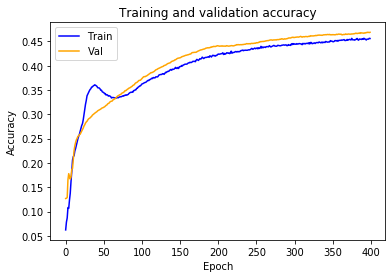

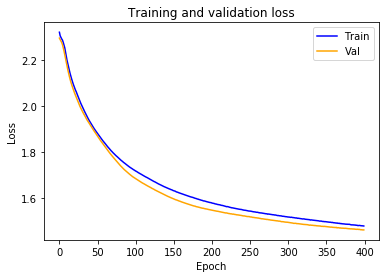

In [9]:
from validation_utils import plot_history
plot_history(history)

In [17]:
import os

try:
    file_path = os.path.join(git_root(), "models","saved_models","glcm_angle0.h5")
    net.save(file_path)
except:
    print('File already exists')

File already exists
